In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import sys
sys.path.append('../')
sys.path.append('../data_processing/')
import os

In [33]:
from torch_geometric.loader import DataLoader
import torch
from torch_scatter import scatter_mean
from tqdm import tqdm
from rdkit import Chem

In [4]:
from data_processing.paired_data import PharmacophoreDataset, CombinedGraphDataset, CombinedSparseGraphDataset
from data_processing.reconstruction import get_atomic_number_from_index, is_aromatic_from_index, reconstruct_from_generated

from model.utils.utils_diffusion import center2zero_sparse_graph
from data_processing.utils import ATOM_TYPE_MAPPING, MAP_ATOMIC_NUMBER_TO_INDEX
from data_processing.reconstruction import get_atomic_number_from_index, is_aromatic_from_index, reconstruct_from_generated

In [5]:
root = '../../data/cleaned_crossdocked_data'
split = 'valid' # 'test
batch_size = 1
num_workers = 0

In [6]:
dataset = CombinedSparseGraphDataset(root, split)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [7]:
dataset.processed_file_names

['valid_combined_sparse_graph.pt']

In [8]:
one = next(iter(dataloader))
one

DataBatch(x=[42, 8], pos=[42, 3], target_x=[42, 8], target_pos=[42, 3], Gt_mask=[42], ligand_name=[1], batch=[42], ptr=[2])

In [9]:
one.batch

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
one.x, one.target_x

(tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0.],
         [0

In [11]:
one.pos, one.target_pos

(tensor([[-33.6430,  20.0160, -16.0670],
         [-33.0150,  18.8310, -16.6210],
         [-34.8090,  19.5130, -15.2280],
         [-35.8880,  20.1450, -15.1760],
         [-34.6810,  18.4420, -14.5820],
         [-32.6070,  20.7390, -15.2030],
         [-32.2540,  19.8800, -14.1440],
         [-33.0640,  22.0860, -14.6460],
         [-32.6380,  23.0990, -15.5230],
         [-32.4860,  22.3700, -13.2630],
         [-32.9830,  23.6070, -12.8030],
         [-31.9590,  24.7910, -12.4470],
         [-31.0490,  24.9840, -13.6410],
         [-31.1650,  24.4080, -11.2230],
         [-32.7060,  26.0700, -12.1540],
         [-34.1160,  20.8960, -17.2160],
         [-34.5140,  20.0980, -18.3010],
         [-35.2120,  20.7990, -19.5640],
         [-36.0410,  21.9670, -19.0790],
         [-34.1410,  21.3130, -20.4930],
         [-36.0640,  19.7770, -20.2790],
         [-33.5676,  21.7784, -15.6491],
         [-33.0121,  18.8383, -16.6158],
         [-35.2929,  19.2908, -14.8717],
         [-35.30

In [12]:
one.Gt_mask.sum()

tensor(21)

In [13]:
centered_pos = center2zero_sparse_graph(one.pos, one.Gt_mask, one.batch)
centered_pos

tensor([[ 0.0504, -1.7216, -0.3850],
        [ 0.6784, -2.9066, -0.9390],
        [-1.1156, -2.2246,  0.4540],
        [-2.1946, -1.5926,  0.5060],
        [-0.9876, -3.2956,  1.1000],
        [ 1.0864, -0.9986,  0.4790],
        [ 1.4394, -1.8576,  1.5380],
        [ 0.6294,  0.3484,  1.0360],
        [ 1.0554,  1.3614,  0.1590],
        [ 1.2074,  0.6324,  2.4190],
        [ 0.7104,  1.8694,  2.8790],
        [ 1.7344,  3.0534,  3.2350],
        [ 2.6444,  3.2464,  2.0410],
        [ 2.5284,  2.6704,  4.4590],
        [ 0.9874,  4.3324,  3.5280],
        [-0.4226, -0.8416, -1.5340],
        [-0.8206, -1.6396, -2.6190],
        [-1.5186, -0.9386, -3.8820],
        [-2.3476,  0.2294, -3.3970],
        [-0.4476, -0.4246, -4.8110],
        [-2.3706, -1.9606, -4.5970],
        [ 0.1258,  0.0408,  0.0330],
        [ 0.6813, -2.8992, -0.9338],
        [-1.5995, -2.4468,  0.8104],
        [-1.6067, -2.4439,  0.8075],
        [-1.5934, -2.4404,  0.8004],
        [ 0.1005,  0.0266,  0.0143],
 

In [14]:
# x = one.original_x[one.batch==1]
# pos = one.original_pos[one.batch==1]

Gt_mask = one.Gt_mask
x = one.x[Gt_mask]
pos = one.pos[Gt_mask]
batch = one.batch
x.size(), pos.size()

(torch.Size([21, 8]), torch.Size([21, 3]))

In [15]:
GT_mask = ~Gt_mask
print(GT_mask)
Gt_mean = scatter_mean(pos, batch[Gt_mask], dim=0)
GT_mean = scatter_mean(one.pos[GT_mask], batch[GT_mask], dim=0)

print(Gt_mean, GT_mean)

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])
tensor([[-33.5731,  21.6110, -15.6025]]) tensor([[-33.6934,  21.7376, -15.6820]])


In [16]:
pos = pos.tolist()
pos

[[-33.643001556396484, 20.016000747680664, -16.066999435424805],
 [-33.01499938964844, 18.83099937438965, -16.621000289916992],
 [-34.808998107910156, 19.51300048828125, -15.227999687194824],
 [-35.88800048828125, 20.145000457763672, -15.175999641418457],
 [-34.680999755859375, 18.441999435424805, -14.581999778747559],
 [-32.606998443603516, 20.73900032043457, -15.20300006866455],
 [-32.25400161743164, 19.8799991607666, -14.144000053405762],
 [-33.06399917602539, 22.086000442504883, -14.645999908447266],
 [-32.63800048828125, 23.099000930786133, -15.52299976348877],
 [-32.486000061035156, 22.3700008392334, -13.262999534606934],
 [-32.983001708984375, 23.60700035095215, -12.803000450134277],
 [-31.958999633789062, 24.791000366210938, -12.446999549865723],
 [-31.048999786376953, 24.983999252319336, -13.640999794006348],
 [-31.165000915527344, 24.408000946044922, -11.222999572753906],
 [-32.70600128173828, 26.06999969482422, -12.154000282287598],
 [-34.11600112915039, 20.895999908447266, 

In [17]:
Gt_mask = one.Gt_mask.view(batch_size, -1)[0]
Gt_mask.sum()

tensor(21)

In [18]:
atom_index = torch.argmax(x, dim=1)
atom_index

tensor([0, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 4, 2, 2, 2, 0, 2, 4, 2, 2, 2])

In [19]:
# atom_type = get_atomic_number_from_index(atom_index)

# for non aromatic data
MAP_INDEX_TO_ATOMIC_NUMBER = {v: k for k, v in MAP_ATOMIC_NUMBER_TO_INDEX.items()}
atom_type = get_atomic_number_from_index(atom_index, mode='nonaro', index_to_atom_type=MAP_INDEX_TO_ATOMIC_NUMBER)
atom_type

[6, 8, 6, 8, 8, 6, 8, 6, 8, 6, 8, 15, 8, 8, 8, 6, 8, 15, 8, 8, 8]

In [20]:
# atom_aromatic = is_aromatic_from_index(atom_index)
atom_aromatic = None
atom_aromatic

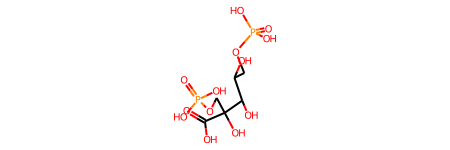

In [21]:
mol = reconstruct_from_generated(pos, atom_type, atom_aromatic)
mol

# Check the original ligand

In [26]:
one.ligand_name

['3zxw_A_rec_3zxw_cap_lig_tt_min_0']

In [31]:
for raw_path in tqdm(dataset.raw_paths):
    filename = raw_path.split('/')[-1].split('.')[0]
    if filename == one.ligand_name[0]:
        print(raw_path)
        break

  0%|                                                                                                                                                                  | 0/22439 [00:00<?, ?it/s]

../../data/cleaned_crossdocked_data/raw/RBL_THEEB_1_475_0/3zxw_A_rec_3zxw_cap_lig_tt_min_0.sdf


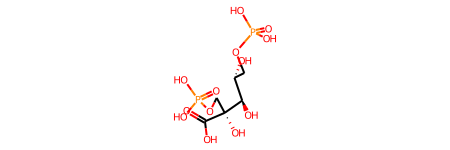

In [34]:
rdmol = Chem.MolFromMolFile(raw_path, sanitize=True)
rdmol